## Install python Captcha lib if not installed

In [1]:
#! pip install captcha

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string
from keras.utils.np_utils import to_categorical

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/ubuntu/anaconda/envs/py36-venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Construct a generator to randomly generate a batch of captchas

Define all characters appearing in captchas, e.g. digits and upper case alphabets.

Each Captcha has 4 letters with size (170, 80)

In [3]:
characters = string.digits + string.ascii_uppercase
width, height, n_len, n_class = 170, 80, 4, len(characters)
print("Number of unique letters in captcha: {}".format(n_class))

Number of unique letters in captcha: 36


In [4]:
def gen(batch_size=16):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y
        

def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])


## Construct the Convolutional neural network

In [5]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))

x = input_tensor
for i in range(4):
    x = Conv2D(filters=32*(2**i), kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(x)
    x = Conv2D(filters=32*(2**i), kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='classifier-%d'%(i+1))(x) for i in range(4)]

model = Model(inputs=input_tensor, outputs=x)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Visualize the deep neural network architecture

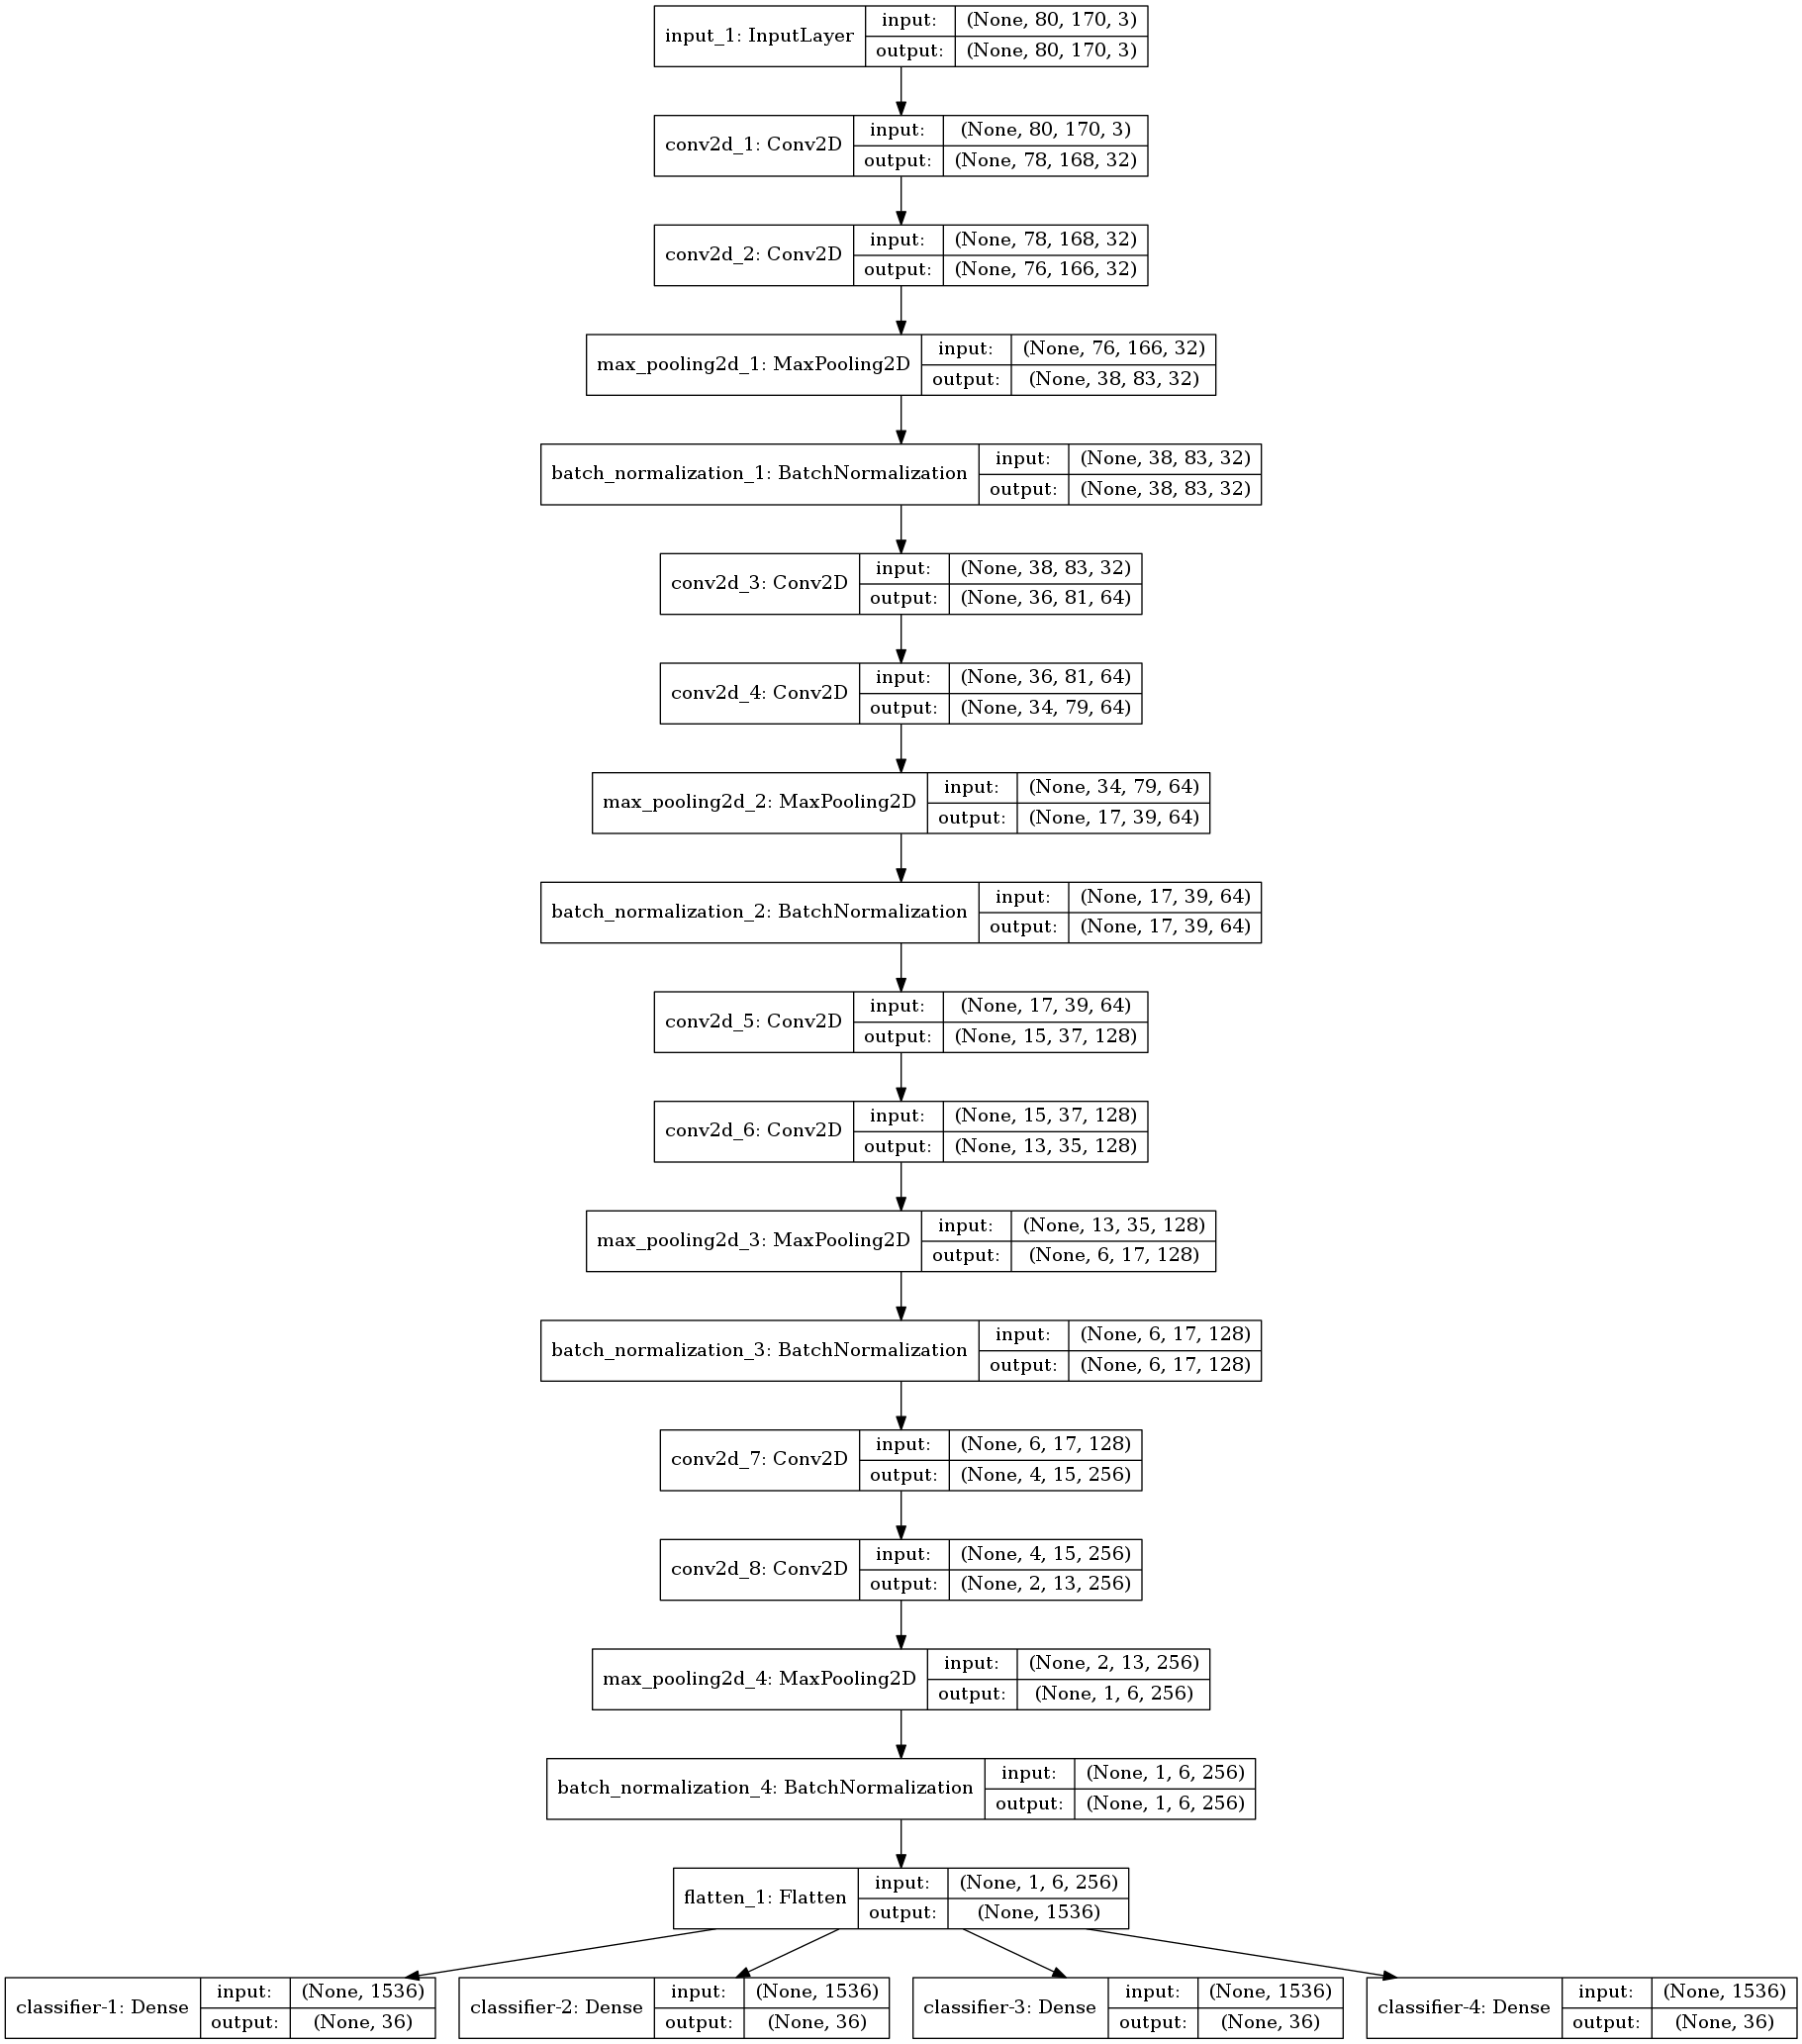

In [11]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="models/model_arch.png", show_shapes=True)
Image('models/model_arch.png')

## Train the CNN model

In [8]:
history = model.fit_generator(
                    gen(), 
                    steps_per_epoch=5120,
                    epochs=10,
                    validation_data=gen(), 
                    validation_steps=1280
                   )

Epoch 1/10
5120/5120 [==============================] - 418s 82ms/step - loss: 1.3698 - classifier-1_loss: 0.3579 - classifier-2_loss: 0.2966 - classifier-3_loss: 0.3899 - classifier-4_loss: 0.3255 - classifier-1_acc: 0.9000 - classifier-2_acc: 0.9131 - classifier-3_acc: 0.8878 - classifier-4_acc: 0.9061 - val_loss: 2.0687 - val_classifier-1_loss: 0.4484 - val_classifier-2_loss: 0.4824 - val_classifier-3_loss: 0.5964 - val_classifier-4_loss: 0.5415 - val_classifier-1_acc: 0.8937 - val_classifier-2_acc: 0.8888 - val_classifier-3_acc: 0.8590 - val_classifier-4_acc: 0.8739
Epoch 2/10
5120/5120 [==============================] - 416s 81ms/step - loss: 0.2974 - classifier-1_loss: 0.0597 - classifier-2_loss: 0.0662 - classifier-3_loss: 0.0975 - classifier-4_loss: 0.0741 - classifier-1_acc: 0.9801 - classifier-2_acc: 0.9784 - classifier-3_acc: 0.9686 - classifier-4_acc: 0.9764 - val_loss: 0.8966 - val_classifier-1_loss: 0.2049 - val_classifier-2_loss: 0.2228 - val_classifier-3_loss: 0.2372 - 

## Save the model weights and architecure config

In [12]:
model.save('models/captcha_model_weight.h5')

model_arch = model.to_yaml()
with open("models/captcha_model_structure.yaml", "w") as text_file:
    text_file.write(model_arch)

## Test a random captcha on the trained model

(-0.5, 169.5, 79.5, -0.5)

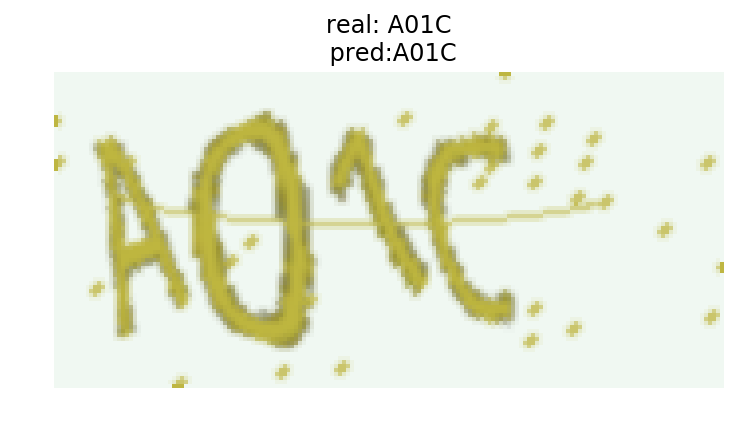

In [13]:
X, y = next(gen(1))
y_pred = model.predict(X)

plt.title('real: %s\n pred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')